In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from catboost import CatBoostClassifier
from src.shap import KernelExplainer, SamplingExplainer

shap_red = "#ff0051"
shap_blue = "#008bfb"

/var/data/python/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

background_data = X_train.iloc[:100]

X_test_shap = X_test.iloc[:100]

In [3]:
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, verbose=0)
model.fit(X_train, y_train)

def predict_function(X):
    return model.predict_proba(X)

In [4]:
def plot_correlation_of_shap_values(first_shap_values, second_shap_values, columns):
    first_shap_flatten, second_shap_flatten = first_shap_values.flatten(), second_shap_values.flatten()
    correlation = np.corrcoef(first_shap_flatten, second_shap_flatten)[0, 1]

    model = LinearRegression()
    model.fit(first_shap_flatten.reshape(-1, 1), second_shap_flatten)

    x_values = np.linspace(min(first_shap_flatten), max(first_shap_flatten), 100)
    y_values = model.predict(x_values.reshape(-1, 1))
    
    plt.figure(figsize=(8, 8))
    plt.scatter(first_shap_values, second_shap_values, color=shap_blue)
    plt.xlabel(columns[0])
    plt.ylabel(columns[1])
    plt.title(f'Correlation: {correlation:.4f}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    min_val = min(np.min(first_shap_values), np.min(second_shap_values))
    max_val = max(np.max(first_shap_values), np.max(second_shap_values))
    plt.plot(x_values, y_values, '--', color=shap_red, alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_comparison_of_shap_values(first_shap_values, second_shap_values, feature_names, number_features=None):
    plt.figure(figsize=(15, 10))
    feature_importance_order = np.argsort(np.abs(first_shap_values))[::-1]
    official_values = first_shap_values[feature_importance_order]
    custom_values = second_shap_values[feature_importance_order]

    if number_features: 
        top_n = number_features
    else:
        top_n = len(feature_names)
    plt.barh(range(top_n), official_values[:top_n], height=0.4, color=shap_blue, alpha=0.9, label='Official SHAP')
    plt.barh(np.arange(top_n) + 0.4, custom_values[:top_n], height=0.4, color=shap_red, alpha=0.7, label='Custom SHAP')
    plt.yticks(np.arange(top_n) + 0.2, feature_names[:top_n])
    plt.xlabel('SHAP Value')
    plt.title('Comparison of SHAP Values (sorted by first sample)')
    plt.legend()
    plt.tight_layout()
    plt.show()


Calculating SHAP values:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating SHAP values: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


Official SHAP expected value: 1.2902139439387872
Custom SHAP expected value: 1.2902139436724187


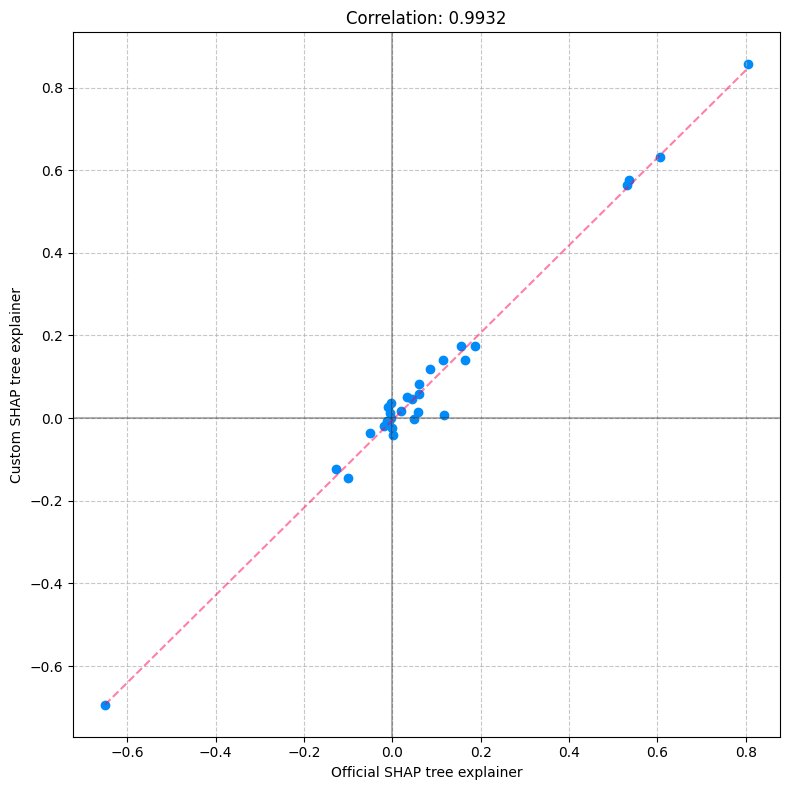

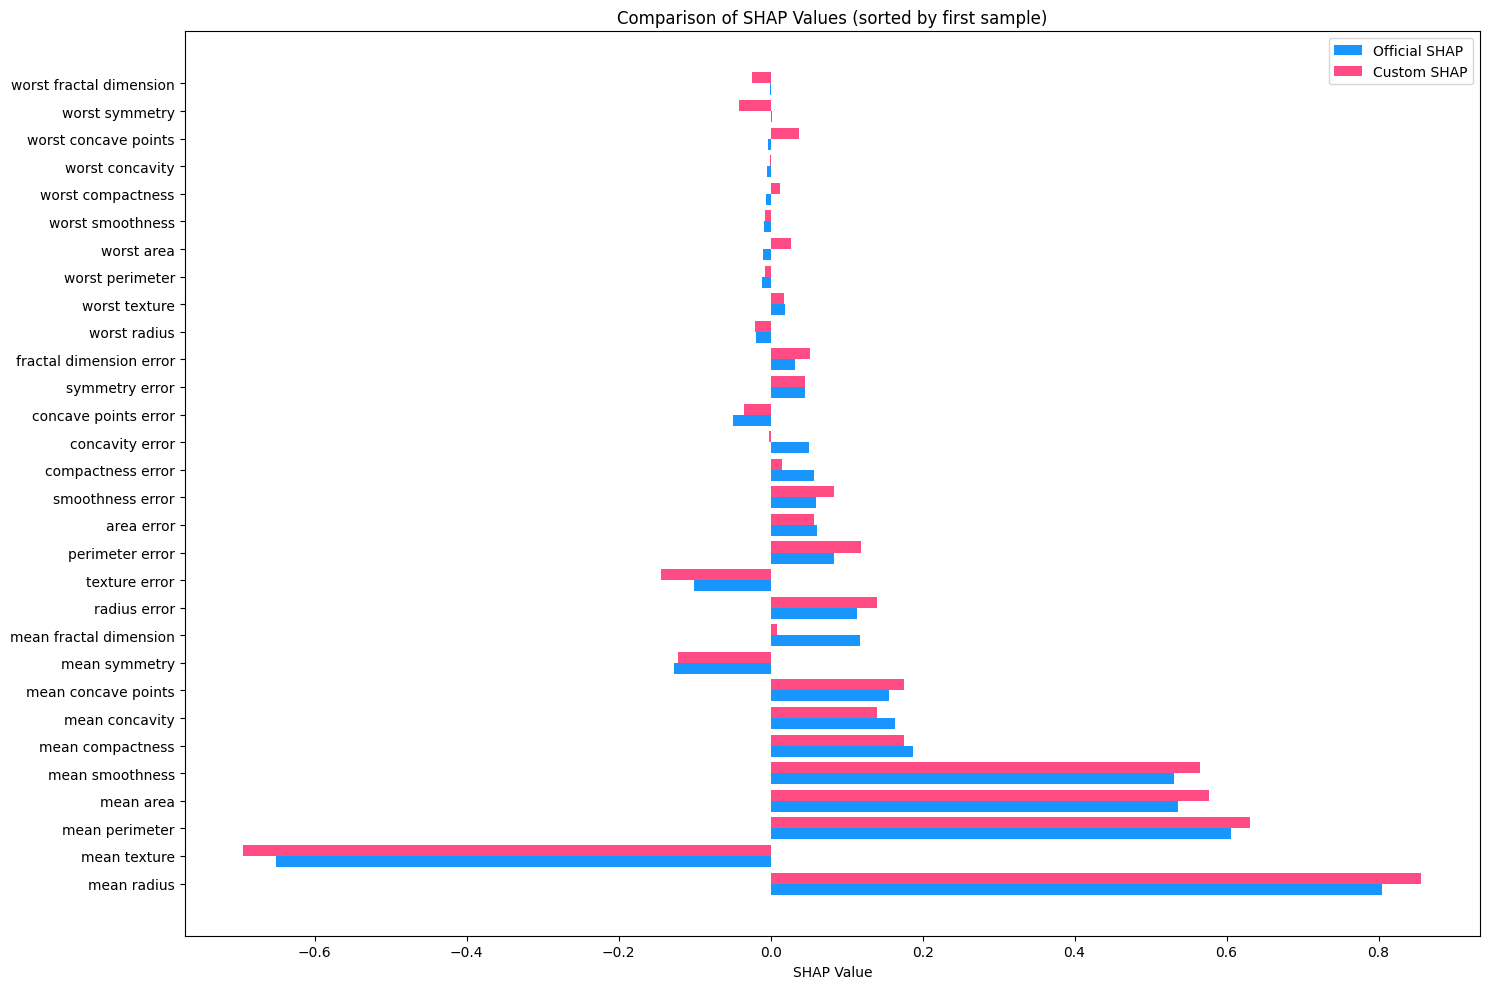

In [5]:
official_tree_explainer = shap.TreeExplainer(model)
official_tree_shap_values = official_tree_explainer.shap_values(X_test_shap)

custom_sampling_explainer = SamplingExplainer(predict_function, X_train)
custom_sampling_shap_values = custom_sampling_explainer.shap_values(X_test_shap, max_samples=len(X_train))

print("Official SHAP expected value:", official_tree_explainer.expected_value)
print("Custom SHAP expected value:", custom_sampling_explainer.expected_value)

plot_correlation_of_shap_values(official_tree_shap_values[0], custom_sampling_shap_values[0], ["Official SHAP tree explainer", "Custom SHAP tree explainer"])
plot_comparison_of_shap_values(official_tree_shap_values[0], custom_sampling_shap_values[0], X.columns)


Calculating SHAP values: 100%|██████████| 100/100 [00:11<00:00,  8.88instance/s]


Official SHAP expected value: 1.2902139439387872
Custom KernelSHAP expected value: [0.32549449 0.67450551]


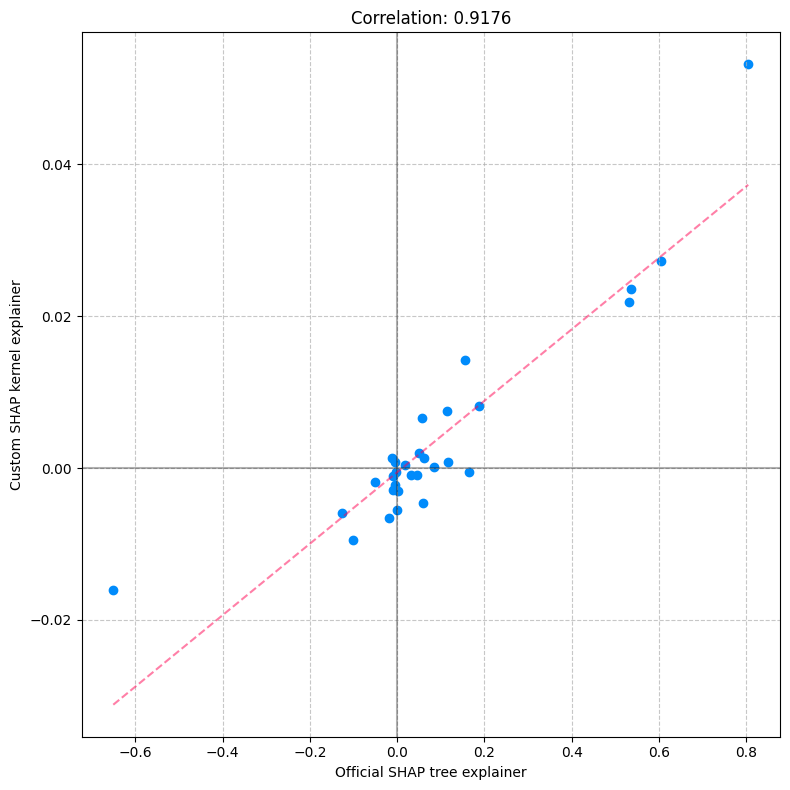

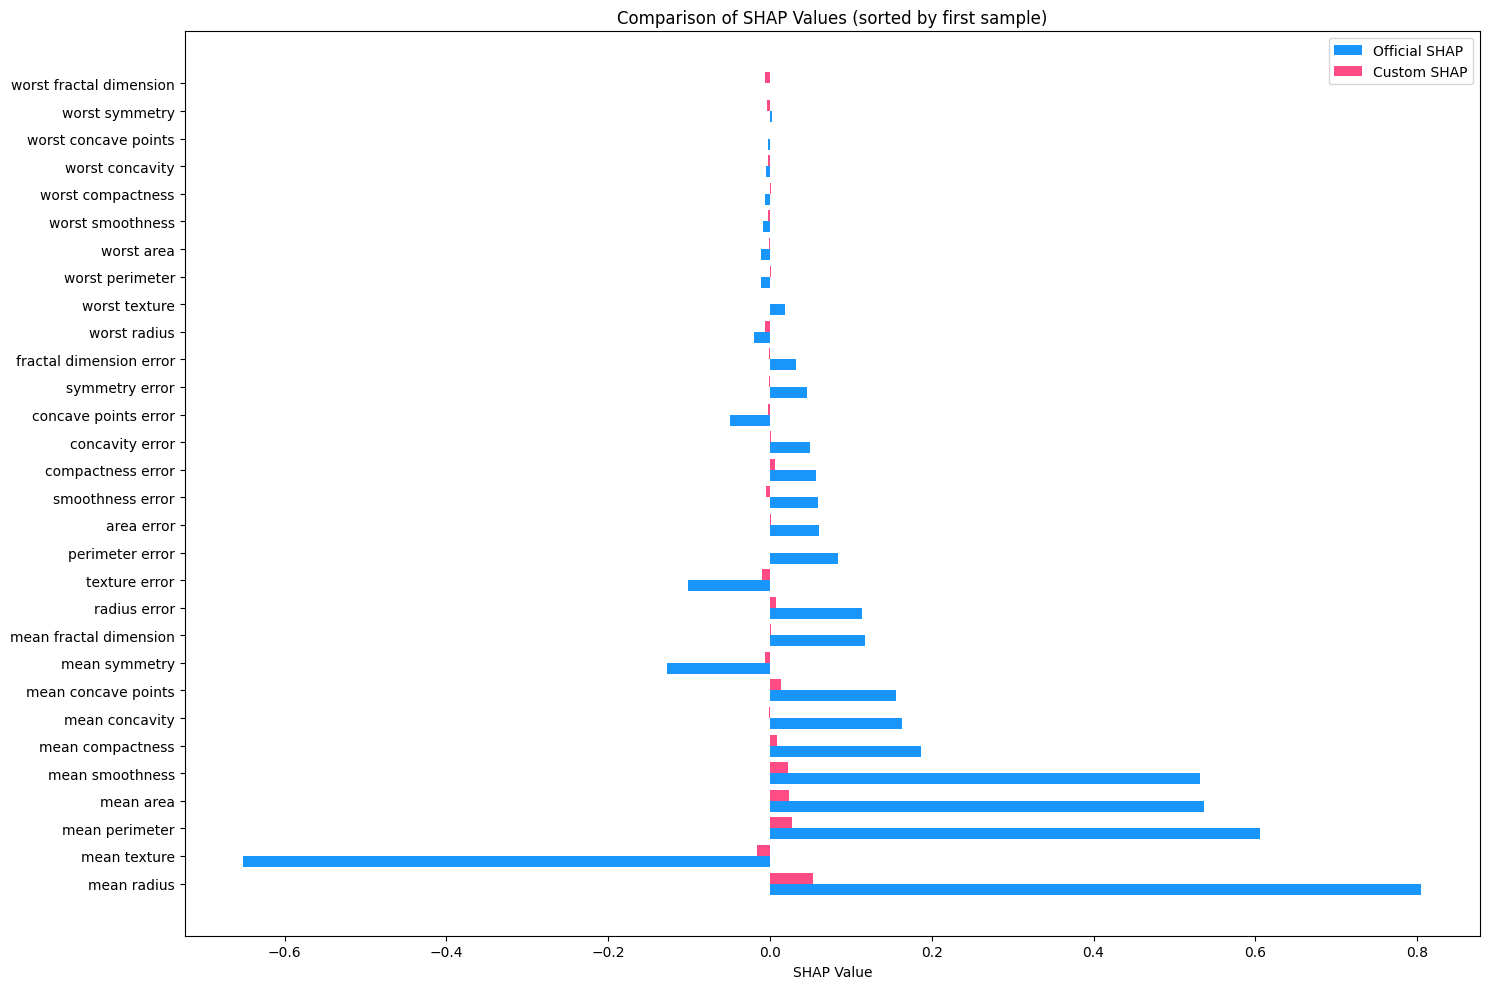

In [6]:
custom_kernel_explainer = KernelExplainer(predict_function, background_data, max_samples=len(X_train), random_state=42)
custom_kernel_shap_values = custom_kernel_explainer.shap_values(X_test_shap)[1]

print("Official SHAP expected value:", official_tree_explainer.expected_value)
print("Custom KernelSHAP expected value:", custom_kernel_explainer.expected_value)

plot_correlation_of_shap_values(official_tree_shap_values[0], custom_kernel_shap_values[0], ["Official SHAP tree explainer", "Custom SHAP kernel explainer"])
plot_comparison_of_shap_values(official_tree_shap_values[0], custom_kernel_shap_values[0], X.columns)
